<a href="https://colab.research.google.com/github/LDBM42/TFM/blob/main/TFM_LuisDavidBetances_EXP_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color='328534' size="5"><strong>Obtención del dataset </strong></font><font color='Black' size="5">Crosswalk</font>

#### **Montar Google Drive y Descargar Dataset** 

<font color='Red' size="3"><strong><i>IMPORTANTE: </i></strong></font><font color='Black' size="3"><i>Ejecutar SIEMPRE que se reinicie Google Colab</i></font>

In [1]:

###################################################################################################
BASE_FOLDER = '/content/drive/My Drive/Master_IA/TFM/'
###################################################################################################

from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import gc # Garbage Collector: para liberar memoria 
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [3]:
def load_images(path, images_name):
  """La nomenclatura del nombre de las imagenes debe ser [[ images_name-numero_4_digitos.jpg ]]"""
  num = "0001"
  x = []
  # Obtener cantidad de archivos en carpeta
  num_files = len(os.listdir(path))

  # Cargar todas las imagenes en orden descendente
  for _ in range(num_files): 
    x.append(np.array(Image.open(path + images_name +"-"+ num + ".jpg")))
    
    if len(str(int(num)+1)) == 1: num = "000" + str(int(num)+1)
    elif len(str(int(num)+1)) == 2: num = "00" + str(int(num)+1)
    elif len(str(int(num)+1)) == 3: num = "0" + str(int(num)+1)
    elif len(str(int(num)+1)) == 4: num = str(int(num)+1)

  # devolver lista como numpy array
  return np.array(x)



# Cargar imagenes y concatenarlas en un solo array
X = load_images(BASE_FOLDER+"crosswalk/", "crosswalk")
# x2 = load_images(BASE_FOLDER+"fourway/", "fourway")
# x3 = load_images(BASE_FOLDER+"night/", "night")



In [4]:
# cargar labels
Y = np.array(pd.read_table(BASE_FOLDER+"crosswalk.csv" ,sep=','))
# Y2 = np.array(pd.read_table(BASE_FOLDER+"fourway.csv" ,sep=','))
# Y3 = np.array(pd.read_table(BASE_FOLDER+"night.csv" ,sep=','))

In [5]:
X2 = []

for i in range(len(X)):
  X2.append(cv2.resize(X[i], dsize=(960, 540), interpolation=cv2.INTER_CUBIC))

X = np.array(X2)
y2 = (Y*50)/100

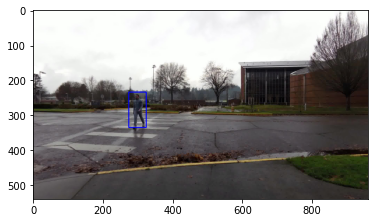

In [11]:
import cv2
num = 300
img = X[num]
img2 = img.copy()

x, y_, w, h = int(y2[num][0]), int(y2[num][1]), int(y2[num][2]), int(y2[num][3]) 
pt1= x, y_
pt2= x+w, y_+h 

cv2.rectangle(img2, pt1=pt1, pt2=pt2, color=(0,0,255), thickness=2)

plt.imshow(img2)
plt.show()

In [46]:
# Revisar dimensiones
print(X.shape)
print(len(Y))

(378, 540, 960, 3)
378


#### **Inspeccionando el conjunto de datos**


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


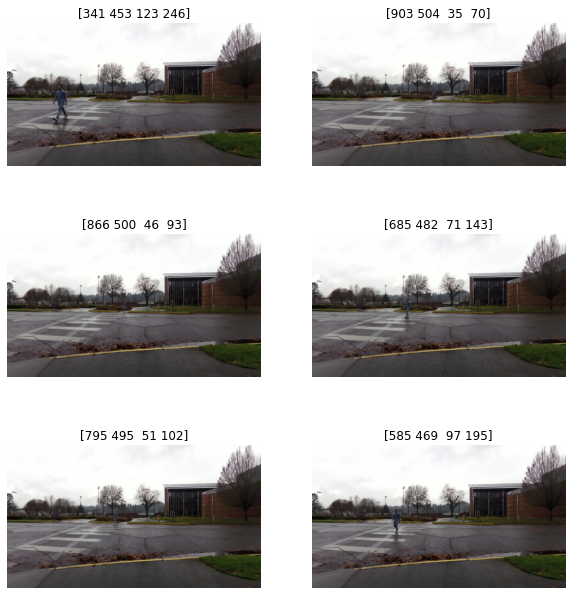

In [ ]:
fig = plt.figure(figsize=(10,11))

# indices de los subplots
index = np.arange(1, 7)
i = 0

# plotear 8 imagenes aleatorias del dataset, con sus etiquetas
for n in np.random.randint(0, len(y), 6): 
    fig.add_subplot(3, 2, index[i])
    
    img = X[n]
    plt.imshow(img)
    label = y[n]
    plt.title(label)
    plt.axis('off')
    
    i += 1 # aumentar indice


## <font color='328534' size="5"><strong>Arquitectura MOBILENET</strong></font>
---
<img src='https://drive.google.com/uc?export=view&id=1y-cepqHzXXu5KkTlGNexs5MnvzmshZTW' width=700px>

---

### <font color='6FBC71' size="4"><strong>-------------TRANSFER LEARNING-------------MOBILENET</strong></font>

---



#### **Acondicionando datos como en la Red MOVILENET**

In [ ]:

from tensorflow.keras.applications import mobilenet
from sklearn.model_selection import train_test_split

# dividir en datos de entrenamiendo, test y validación
x_tr, x_te, y_tr, y_te = train_test_split(X, y2, test_size=0.2, random_state=10) # 20% para datos de test

# preprocesando los datos como ImageNet
# x_tr = mobilenet.preprocess_input(x_tr)                                            # Datos de train preprocesados como MobileNet
# x_te = mobilenet.preprocess_input(x_te)                                            # Datos de test preprocesados


In [ ]:

print('x train:', x_tr.shape)
print('y train:', y_tr.shape, '\n')

print('x test: ', x_te.shape)
print('y test: ', y_te.shape, '\n')


x train: (302, 540, 960, 3)
y train: (302, 4) 

x test:  (76, 540, 960, 3)
y test:  (76, 4) 



#### **Cargando la topología de CNN (base model)**

In [ ]:

from tensorflow.keras.applications import MobileNet # Importamos modelo pre-entrenado MobileNet

input_shape = x_tr[0, :, :, :].shape                # Dimensiones de los datos de entrada

base_model = MobileNet(weights='imagenet',          # Traemos los pesos de imagenet
                       include_top=False,           # No incluir el top model
                       input_shape=input_shape,     # Se incluye el nuevo input shape
                       pooling='max')               # Se le aplica un global max pooling

base_model.summary()


#### **Creando el Top Model y realizamos el TRANSFER LEARNING**

In [ ]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout

base_model.trainable = False # Congelamos las capas Conv2D

inputs = Input(shape=input_shape)

## BASE MODEL PREENTRENADO ##
# training=False es para que las capas de BatchNormalization se mantengan en modo de inferencia
# esto sirve para que al realizar el fine tuning (el proximo paso) sobre este modelo preentrenado, 
# los nuevos updates de los pesos no destruyan lo que el modelo aprenda en este paso (Transfer Learning)
# https://www.tensorflow.org/guide/keras/transfer_learning
tlm = base_model(inputs, training=False) 

## TOP MODEL ##
tlm = Dense(512, activation='relu')(tlm)  # 512 neuronas debido a que la salida del base model con el 'global_max_pooling2d'  es 1024
tlm = Dense(256, activation='relu')(tlm)
outputs = Dense(4, activation='linear')(tlm)

transfer_learning_model = Model(inputs=inputs, outputs=outputs)

transfer_learning_model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 540, 960, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 1024)              3228864   
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 3,886,020
Trainable params: 657,156
Non-trainable params: 3,228,864
_________________________________________________________________


#### **Funcion Auxiliar**

In [ ]:

import gc # Garbage Collector: para liberar memoria 
from tensorflow.keras.callbacks import Callback

# Callback personalizado para incluir en la lista de callbacks mientras entrenamos el modelo
# Este libera memoria al finalizar cada epoch
class GarbageCollectorCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect() # liberar memoria con garbage collector
        

#### **Entrenando el modelo**

In [ ]:

# Importamos los paquetes necesarios
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from google.colab import drive


In [ ]:

# Compilar el modelo
transfer_learning_model.compile(loss="categorical_crossentropy", optimizer=Adam(), metrics=["accuracy"]) 

# Entrenamiento de la CNN
epochs = 20
batch_size = 16
# Se detendrá el entrenamiento cuando no haya mejoras en el loss validation por 3 epochs consecutivas
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

print("[INFO]: Entrenando la CNN...\n")
H_TRANSFER_LEARNING = transfer_learning_model.fit(x_tr, y_tr, validation_split=0.2, batch_size=batch_size, 
                                                  epochs=epochs, callbacks=[GarbageCollectorCallback(), early_stopping])


[INFO]: Entrenando la CNN...

Epoch 1/20
16/16 [==============================] - 13s 282ms/step - loss: 7988.6582 - accuracy: 0.8827 - val_loss: 9461.3213 - val_accuracy: 0.8033
Epoch 2/20
16/16 [==============================] - 4s 228ms/step - loss: 9928.3991 - accuracy: 0.8906 - val_loss: 9461.3213 - val_accuracy: 0.8033
Epoch 3/20
16/16 [==============================] - 4s 226ms/step - loss: 9961.9018 - accuracy: 0.8891 - val_loss: 9461.3213 - val_accuracy: 0.8033
Epoch 4/20
16/16 [==============================] - 4s 228ms/step - loss: 9883.3956 - accuracy: 0.8740 - val_loss: 9461.3213 - val_accuracy: 0.8033


#### **Observando el proceso de entrenamiento**

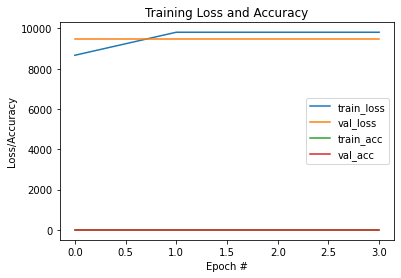

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

H=H_TRANSFER_LEARNING

X = np.arange(0, len(H_TRANSFER_LEARNING.epoch))

# plotear Gráfica
plt.plot(X, H.history["loss"], label="train_loss")
plt.plot(X, H.history["val_loss"], label="val_loss")
plt.plot(X, H.history["accuracy"], label="train_acc")
plt.plot(X, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()


In [ ]:
del H_TRANSFER_LEARNING # Borrar el historial H_TRANSFER_LEARNING
gc.collect()

4673

**Guardando el modelo y realizando Predicciones**

In [ ]:

# Almaceno el modelo en Google Drive 
transfer_learning_model.save(BASE_FOLDER+"deepCNN_MobileNet_TRANSFER_LEARNING.h5") 

# Evaluación del modelo
print("[INFO]: Evaluando el modelo...\n")
y_pred = transfer_learning_model.predict(x_te, batch_size=batch_size)

# Sacamos el report para test
print(classification_report(y_te.argmax(axis=1), y_pred.argmax(axis=1), target_names=np.unique(y_train))) 


### <font color='6FBC71' size="4"><strong>------------------FINE-TUNING------------------MOBILENET</strong></font>

---
<font color='Red' size="3"><strong><i>IMPORTANTE: </i></strong></font><font color='Black' size="3"><i>Realizar este paso luego del paso anterior -> transfer learning.</i></font>



#### **Realizando FINE-TUNING**

In [ ]:

# descongelamos el base model
base_model.trainable = True

# En este caso solo congelamos las capas hasta el 2do bloque convolucional, 
# del 3ro para abajo se re-entrena
for layer in base_model.layers:
  if layer.name == 'conv_dw_3': break 
  layer.trainable = False # congelar todas las capas que no queramos reentrenar
  print('Capa ' + layer.name + ' congelada...') 

transfer_learning_model.summary()


Capa input_1 congelada...
Capa conv1 congelada...
Capa conv1_bn congelada...
Capa conv1_relu congelada...
Capa conv_dw_1 congelada...
Capa conv_dw_1_bn congelada...
Capa conv_dw_1_relu congelada...
Capa conv_pw_1 congelada...
Capa conv_pw_1_bn congelada...
Capa conv_pw_1_relu congelada...
Capa conv_pad_2 congelada...
Capa conv_dw_2 congelada...
Capa conv_dw_2_bn congelada...
Capa conv_dw_2_relu congelada...
Capa conv_pw_2 congelada...
Capa conv_pw_2_bn congelada...
Capa conv_pw_2_relu congelada...
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 540, 960, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 1024)              3228864   
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
____________________

#### **Entrenando el modelo**

In [ ]:

# Compilar el modelo
# Según la documentación en esta fase se debe aplicar un learing_rate bien pequeño 
# ya que estaremos entrenando un modelo más grande en un dataset más pequeño, esto para evitar overfitting.
transfer_learning_model.compile(loss="categorical_crossentropy", optimizer=Adam(1e-5), metrics=["accuracy"]) 

# Entrenamiento de la CNN
epochs = 20 # pocas epocas ya que el modelo está pre-entrenado
batch_size = 16 
# Se detendrá el entrenamiento cuando no haya mejoras en el loss validation por 3 epochs consecutivas
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

print("[INFO]: Entrenando la CNN...\n")
H_FINE_TUNING = transfer_learning_model.fit(x_tr, y_tr, validation_split=0.2, batch_size=batch_size, 
                                                  epochs=epochs, callbacks=[GarbageCollectorCallback(), early_stopping])


[INFO]: Entrenando la CNN...

Epoch 1/20
16/16 [==============================] - 13s 654ms/step - loss: 9910.6093 - accuracy: 0.8944 - val_loss: 9461.3213 - val_accuracy: 0.8033
Epoch 2/20
16/16 [==============================] - 10s 642ms/step - loss: 9853.6050 - accuracy: 0.8709 - val_loss: 9461.3213 - val_accuracy: 0.8033
Epoch 3/20
16/16 [==============================] - 10s 636ms/step - loss: 9760.5217 - accuracy: 0.8713 - val_loss: 9461.3213 - val_accuracy: 0.8033
Epoch 4/20
16/16 [==============================] - 10s 624ms/step - loss: 9796.2942 - accuracy: 0.8788 - val_loss: 9461.3213 - val_accuracy: 0.8033


#### **Observando el proceso de entrenamiento**

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

H = H_FINE_TUNING

X = np.arange(0, len(H_FINE_TUNING.epoch))

# plotear Gráfica
plt.plot(X, H.history["loss"], label="train_loss")
plt.plot(X, H.history["val_loss"], label="val_loss")
plt.plot(X, H.history["accuracy"], label="train_acc")
plt.plot(X, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()


#### **Guardando el modelo y realizando Predicciones**

In [ ]:

# Almaceno el modelo de Fine-Tuning en Google Drive 
transfer_learning_model.save(BASE_FOLDER+"prueba_reconocimiento_persona.h5") 


In [ ]:

from sklearn import metrics

# Evaluación del modelo
print("[INFO]: Evaluando el modelo...\n")
y_pred = transfer_learning_model.predict(x_te)

metrics.mean_absolute_error(y_te, y_pred)

[INFO]: Evaluando el modelo...



197.2117082445245

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


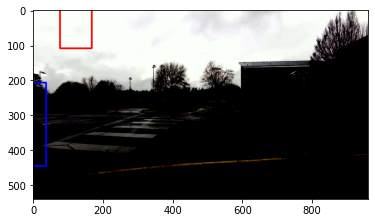

In [ ]:
num = 0
img = x_te[num]
img2 = img.copy()
y2 = y_te
img2 = cv2.resize(img2, dsize=(960, 540), interpolation=cv2.INTER_CUBIC)
x, y_, w, h = int(y2[num][0]), int(y2[num][1]), int(y2[num][2]), int(y2[num][3]) 
pt1= x, y_
pt2= x+w, y_+h 


x2, y2_, w2, h2 = int(y_pred[num][0]), int(y_pred[num][1]), int(y_pred[num][2]), int(y_pred[num][3]) 
pt1_2= x2, y2_
pt2_2= x2+w2, y2_+h2 

cv2.rectangle(img2, pt1=pt1, pt2=pt2, color=(0,0,255), thickness=3)
cv2.rectangle(img2, pt1=pt1_2, pt2=pt2_2, color=(255,0,0), thickness=3)

plt.imshow(img2)
plt.show()

# Experimento con groundtruth normalizado

In [12]:
# alto y ancho de la imagen
H, W = np.shape(X)[1:3]
print("W=" + str(W), "H=" + str(H))

W=960 H=540


In [13]:
#Almacenar groundtruth en variables separadas y redimensionar entre 0 y 1
x, y, w, h = y2[:,0]/W, y2[:,1]/H, y2[:,2]/W, y2[:,3]/H

In [16]:
# Estructura del groundtruth
print("X=" + str(x[0]) + "\nY=" + str(y[0]) + "\nW=" + str(w[0]) + "\nH=" + str(h[0]))

X=0.559375
Y=0.462037037037037
W=0.019270833333333334
H=0.06944444444444445


In [17]:
#Colocar el groundtruth nuevamente en una sola variable
y_=[]
for i in range(x.shape[0]):
  y_.append([x[i], y[i], w[i], h[i]])

Y = np.array(y_)

# imprimir dimensiones
Y.shape

(378, 4)

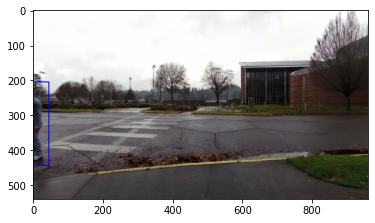

In [22]:
# import cv2

# mostrar imagen random con su bounding box
num = np.random.randint(0,X.shape[0])
img = X[num]
img2 = img.copy()

x_temp, y_temp, w_temp, h_temp = int(x[num]*W), int(y[num]*H), int(w[num]*W), int(h[num]*H) 
pt1= x_temp, y_temp
pt2= x_temp+w_temp, y_temp+h_temp 

cv2.rectangle(img2, pt1=pt1, pt2=pt2, color=(0,0,255), thickness=2)

plt.imshow(img2)
plt.show()

### <font color='6FBC71' size="4"><strong>-------------TRANSFER LEARNING-------------MOBILENET</strong></font>

---



**Acondicionando datos como en la Red MOVILENET**
Se realiza la división del dataset en entrenamiento, prueba y validación. Por ultimo realizamos el pre procesado de los datos como estaba en ImageNet, especificamente como lo trabajó MobileNet.

In [24]:

from tensorflow.keras.applications import mobilenet
from sklearn.model_selection import train_test_split

# dividir en datos de entrenamiendo, test y validación
x_tr, x_te, y_tr, y_te = train_test_split(X, Y, test_size=0.2, random_state=10) # 20% para datos de test

# preprocesando los datos como ImageNet
# x_tr = mobilenet.preprocess_input(x_tr)                                            # Datos de train preprocesados como MobileNet
# x_te = mobilenet.preprocess_input(x_te)                                            # Datos de test preprocesados


In [27]:
# guardar datos de prueba para usar en cualquier momento
np.save(BASE_FOLDER+"img_test_datasets_Crosswalk.npy", x_te)
np.save(BASE_FOLDER+'img_test_datasets_Crosswalk_labels.npy', y_te)

In [25]:

print('x train:', x_tr.shape)
print('y train:', y_tr.shape, '\n')

print('x test: ', x_te.shape)
print('y test: ', y_te.shape, '\n')


x train: (302, 540, 960, 3)
y train: (302, 4) 

x test:  (76, 540, 960, 3)
y test:  (76, 4) 



#### **Cargando la topología de CNN (base model)**

In [36]:

from tensorflow.keras.applications import MobileNet # Importamos modelo pre-entrenado MobileNet

input_shape = x_tr[0, :, :, :].shape                # Dimensiones de los datos de entrada

base_model = MobileNet(weights='imagenet',          # Traemos los pesos de imagenet
                       include_top=False,           # No incluir el top model
                       input_shape=input_shape,     # Se incluye el nuevo input shape
                       pooling='max')               # Se le aplica un global max pooling

base_model.summary()


Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 540, 960, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 270, 480, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 270, 480, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 270, 480, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 270, 480, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 270, 480, 32)      128       
_________________________________________________________________
conv_dw_1_relu (ReLU)        (None, 270, 480, 32

**Creando el Top Model y realizamos el TRANSFER LEARNING**

En esta ocasion utilizaré el Functional API para crear el modelo.

In [37]:

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout

base_model.trainable = False # Congelamos las capas Conv2D

inputs = Input(shape=input_shape)

## BASE MODEL PREENTRENADO ##
# training=False es para que las capas de BatchNormalization se mantengan en modo de inferencia
# esto sirve para que al realizar el fine tuning (el proximo paso) sobre este modelo preentrenado, 
# los nuevos updates de los pesos no destruyan lo que el modelo aprenda en este paso (Transfer Learning)
# https://www.tensorflow.org/guide/keras/transfer_learning
tlm = base_model(inputs, training=False) 

## TOP MODEL ##
tlm = Dense(512, activation='relu')(tlm)  # 512 neuronas debido a que la salida del base model con el 'global_max_pooling2d'  es 1024
tlm = Dense(256, activation='relu')(tlm)
outputs = Dense(4, activation='linear')(tlm)

transfer_learning_model = Model(inputs=inputs, outputs=outputs)

transfer_learning_model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 540, 960, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 1024)              3228864   
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 1028      
Total params: 3,886,020
Trainable params: 657,156
Non-trainable params: 3,228,864
_________________________________________________________________


**Funcion Auxiliar**

In [29]:

import gc # Garbage Collector: para liberar memoria 
from tensorflow.keras.callbacks import Callback

# Callback personalizado para incluir en la lista de callbacks mientras entrenamos el modelo
# Este libera memoria al finalizar cada epoch
class GarbageCollectorCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect() # liberar memoria con garbage collector
        

#### **Entrenando el modelo**

In [32]:

# Importamos los paquetes necesarios
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report
from google.colab import drive


In [38]:

# Compilar el modelo
transfer_learning_model.compile(loss="mse", optimizer=Adam()) 

# Entrenamiento de la CNN
epochs = 50
batch_size = 16
# Se detendrá el entrenamiento cuando no haya mejoras en el loss validation por 15 epochs consecutivas
early_stopping = EarlyStopping(monitor='val_loss', patience=15)

# Almaceno el mejor modelo en Google Drive 
# checkpoint
filepath = BASE_FOLDER+"deepCNN_MOBILENET_TRANSFER_LEARNING_Person_Recognition_datasets_16_CROSSWALK.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')


print("[INFO]: Entrenando la CNN...\n")
H_TRANSFER_LEARNING = transfer_learning_model.fit(x_tr, y_tr, validation_split=0.2, batch_size=batch_size, 
                                                  epochs=epochs, callbacks=[GarbageCollectorCallback(), early_stopping])


[INFO]: Entrenando la CNN...

Epoch 1/50
16/16 [==============================] - 5s 212ms/step - loss: 41.8263 - val_loss: 0.3424
Epoch 2/50
16/16 [==============================] - 3s 187ms/step - loss: 0.5715 - val_loss: 0.3267
Epoch 3/50
16/16 [==============================] - 3s 187ms/step - loss: 0.2292 - val_loss: 0.2935
Epoch 4/50
16/16 [==============================] - 3s 186ms/step - loss: 0.2059 - val_loss: 0.0563
Epoch 5/50
16/16 [==============================] - 3s 187ms/step - loss: 0.0908 - val_loss: 0.0564
Epoch 6/50
16/16 [==============================] - 3s 188ms/step - loss: 0.0485 - val_loss: 0.0906
Epoch 7/50
16/16 [==============================] - 3s 188ms/step - loss: 0.0598 - val_loss: 0.0692
Epoch 8/50
16/16 [==============================] - 3s 187ms/step - loss: 0.0554 - val_loss: 0.0955
Epoch 9/50
16/16 [==============================] - 3s 189ms/step - loss: 0.0394 - val_loss: 0.1015
Epoch 10/50
16/16 [==============================] - 3s 189ms/step - 

#### **Observando el proceso de entrenamiento**

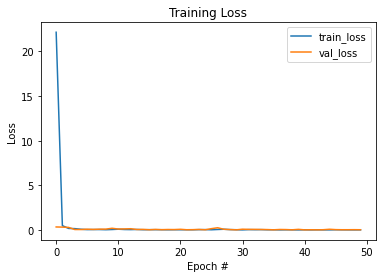

In [40]:

import numpy as np
import matplotlib.pyplot as plt

H=H_TRANSFER_LEARNING

XH = np.arange(0, len(H_TRANSFER_LEARNING.epoch))

# plotear Gráfica
plt.plot(XH, H.history["loss"], label="train_loss")
plt.plot(XH, H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [41]:
import json
# conseguir el dic con las metricas de cada epoch
h_dict = H_TRANSFER_LEARNING.history

filepath = BASE_FOLDER+"deepCNN_MOBILENET_TRANSFER_LEARNING_Person_Recognition_datasets_16_CROSSWALK.json"
# Guardar el history como un json
json.dump(h_dict, open(filepath, 'w'))

### <font color='6FBC71' size="4"><strong>------------------FINE-TUNING------------------MOBILENET</strong></font>

---
<font color='Red' size="3"><strong><i>IMPORTANTE: </i></strong></font><font color='Black' size="3"><i>Realizar este paso luego de realizar el paso anterior -> transfer learning.</i></font>



**Realizando FINE-TUNING**

In [42]:

# descongelamos el base model
base_model.trainable = True

# En este caso solo congelamos las capas hasta el 2do bloque convolucional, 
# del 3ro para abajo se re-entrena
for layer in base_model.layers:
  if layer.name == 'conv_dw_3': break 
  layer.trainable = False # congelar todas las capas que no queramos reentrenar
  print('Capa ' + layer.name + ' congelada...') 

transfer_learning_model.summary()


Capa input_3 congelada...
Capa conv1 congelada...
Capa conv1_bn congelada...
Capa conv1_relu congelada...
Capa conv_dw_1 congelada...
Capa conv_dw_1_bn congelada...
Capa conv_dw_1_relu congelada...
Capa conv_pw_1 congelada...
Capa conv_pw_1_bn congelada...
Capa conv_pw_1_relu congelada...
Capa conv_pad_2 congelada...
Capa conv_dw_2 congelada...
Capa conv_dw_2_bn congelada...
Capa conv_dw_2_relu congelada...
Capa conv_pw_2 congelada...
Capa conv_pw_2_bn congelada...
Capa conv_pw_2_relu congelada...
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 540, 960, 3)]     0         
_________________________________________________________________
mobilenet_1.00_224 (Function (None, 1024)              3228864   
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
__________________

**Entrenando el modelo**

In [44]:

lr = 1e-5
epochs = 100
batch_size = 16


# Compilar el modelo
transfer_learning_model.compile(loss="mse", optimizer=Adam(lr)) 

# Entrenamiento de la CNN
# Se detendrá el entrenamiento cuando no haya mejoras en el loss validation por 10 epochs consecutivas
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Almaceno el mejor modelo en Google Drive 
# checkpoint
filepath = BASE_FOLDER+"deepCNN_MOBILENET_FINE_TUNING_Person_Recognition_datasets_16_CROSSWALK.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

print("[INFO]: Entrenando la CNN...\n")
H_TRANSFER_LEARNING = transfer_learning_model.fit(x_tr, y_tr, validation_split = 0.2, batch_size=batch_size, 
                                                  epochs=epochs, callbacks=[GarbageCollectorCallback(), early_stopping, checkpoint], verbose=1)



[INFO]: Entrenando la CNN...

Epoch 1/100
16/16 [==============================] - 11s 598ms/step - loss: 0.0563 - val_loss: 0.0177

Epoch 00001: val_loss improved from inf to 0.01766, saving model to /content/drive/My Drive/Master_IA/TFM/deepCNN_MOBILENET_FINE_TUNING_Person_Recognition_datasets_16_CROSSWALK.h5
Epoch 2/100
16/16 [==============================] - 9s 568ms/step - loss: 0.0120 - val_loss: 0.0182

Epoch 00002: val_loss did not improve from 0.01766
Epoch 3/100
16/16 [==============================] - 9s 570ms/step - loss: 0.0094 - val_loss: 0.0145

Epoch 00003: val_loss improved from 0.01766 to 0.01449, saving model to /content/drive/My Drive/Master_IA/TFM/deepCNN_MOBILENET_FINE_TUNING_Person_Recognition_datasets_16_CROSSWALK.h5
Epoch 4/100
16/16 [==============================] - 9s 573ms/step - loss: 0.0066 - val_loss: 0.0110

Epoch 00004: val_loss improved from 0.01449 to 0.01096, saving model to /content/drive/My Drive/Master_IA/TFM/deepCNN_MOBILENET_FINE_TUNING_Person

In [4]:
history = {"loss":[0.0563,0.0120,0.0094,0.0066,0.0036,0.0029,0.0030,0.0026,0.0028,0.0025,0.0016,8.5846e-04,0.0014,0.0015,0.0016,0.0016,0.0010,0.0018,0.0033,0.0039,0.0046,0.0026,0.0033,0.0033,0.0030,0.0041,0.0082,0.0080,0.0056,0.0049,0.0042],
"val_loss":[0.0177,0.0182,0.0145,0.0110,0.0102,0.0131,0.0134,0.0108,0.0112,0.0107,0.0104,0.0108,0.0098,0.0103,0.0104,0.0103,0.0116,0.0127,0.0120,0.0138,0.0093,0.0132,0.0104,0.0109,0.0106,0.0100,0.0141,0.0098,0.0127,0.0095,0.0132]}

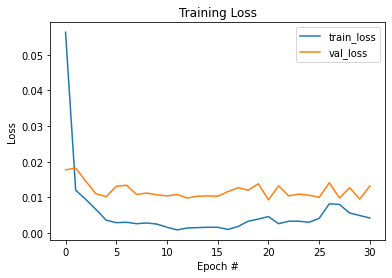

In [8]:

import numpy as np
import matplotlib.pyplot as plt

H = np.arange(0, 31)

# plotear Gráfica
plt.plot(H, history["loss"], label="train_loss")
plt.plot(H, history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()


**Realizando Predicciones**

In [47]:

from tensorflow.keras.models import load_model
import imutils

#Cargar imagenes de prueba y labels
imgs = np.load(BASE_FOLDER+"img_test_datasets_Crosswalk.npy")
y = np.load(BASE_FOLDER+'img_test_datasets_Crosswalk_labels.npy')

# modelos
model_FT = load_model(BASE_FOLDER+"deepCNN_MOBILENET_FINE_TUNING_Person_Recognition_datasets_16_CROSSWALK.h5")

# Evaluación del modelo
y_pred_FT = model_FT.predict(imgs)


In [48]:
from sklearn.metrics import r2_score, mean_absolute_error,  mean_squared_error, make_scorer

metricas = {
  'MAE' : lambda y, y_pred: mean_absolute_error(y, y_pred),
  'MSE' : lambda y, y_pred: mean_squared_error(y, y_pred),
  'RMSE': lambda y, y_pred: mean_squared_error(y, y_pred, squared=False), # squared=False devuelve RMSE,
  'R2'  : lambda y, y_pred: r2_score(y, y_pred)}

In [49]:

MAE = round(metricas['MAE'](y, y_pred_FT), 4)
MSE = round(metricas['MSE'](y, y_pred_FT), 4)
RMSE = round(metricas['RMSE'](y, y_pred_FT), 4)
R2 = round(metricas['R2'](y, y_pred_FT), 4)

print('mean absolute error:\t', MAE)
print('mean squared error:\t', MSE)
print('root mean quared error:\t', RMSE)
print('r2 score:\t\t', R2)

mean absolute error:	 0.0734
mean squared error:	 0.0084
root mean quared error:	 0.0917
r2 score:		 -5.5329


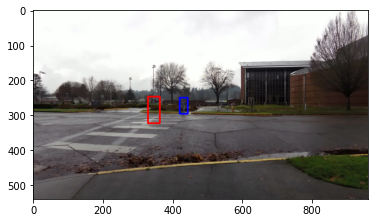

In [70]:
num = np.random.randint(0,imgs.shape[0])
img = imgs[num]
img2 = img.copy()
H2, W2 = img.shape[:2]


x, y_, w, h = int(y[num][0]*W2), int(y[num][1]*H2), int(y[num][2]*W2), int(y[num][3]*H2) 
pt1= x, y_
pt2= x+w, y_+h 


x2, y2_, w2, h2 = int(y_pred_FT[num][0]*W2), int(y_pred_FT[num][1]*H2), int(y_pred_FT[num][2]*W2), int(y_pred_FT[num][3]*H2) 
pt1_2= x2, y2_
pt2_2= x2+w2, y2_+h2 

cv2.rectangle(img2, pt1=pt1, pt2=pt2, color=(0,0,255), thickness=3)
cv2.rectangle(img2, pt1=pt1_2, pt2=pt2_2, color=(255,0,0), thickness=3)

plt.imshow(img2)
plt.show()